In [1]:
import numpy as np
import h5py
import meshio
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, cm
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

from importlib import reload

import FEM_tools
from FEM_tools import *

In [2]:
def CPlot2D(Cx, dpi=100, cmap='RdBu_r'):
                
    fig, ax = plt.subplots(1, 1, figsize=(1*56.25/25.4, 1.5*56.25/25.4), dpi=dpi, tight_layout=True)
    
    c = ax.contourf(Cx, 256, cmap=cmap, vmin=Cx.min(), vmax=Cx.max())
    cbar = fig.colorbar(c, ax=ax, ticks=np.linspace(Cx.min(), Cx.max(), 4), orientation="horizontal", pad=0.05)

    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])

#### Read order parameters

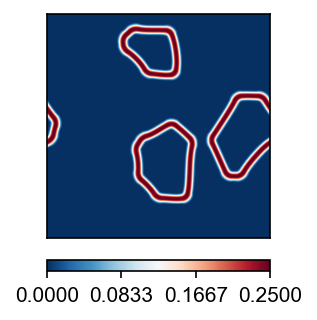

In [3]:
with h5py.File("Two_Phase_RVE.hdf5", "r") as fh5:
    gPhi_ii = fh5["gPhi_ii"][()]
    gPhi_ij = fh5["gPhi_ij"][()]
    gPhi_jj = fh5["gPhi_jj"][()]
    phi_j = fh5["phi_j"][()]

CPlot2D(gPhi_ij, dpi=150)

### Resample 

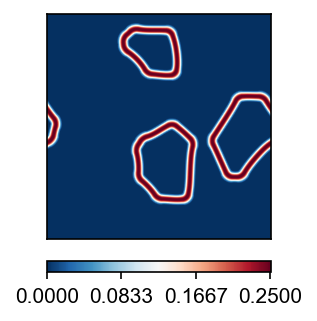

In [ ]:
Mx = 1000 # New array size
gPhi_ii_resamp = Resample2D(gPhi_ii, Mx)
gPhi_ij_resamp = Resample2D(gPhi_ij, Mx)
gPhi_jj_resamp = Resample2D(gPhi_jj, Mx)
phi_j_resamp = Resample2D(phi_j, Mx)

CPlot2D(gPhi_ij_resamp, dpi=150)

### Develop a structured finite element mesh using Gmsh for interpolation

In [7]:
Lx = 100e-6 # RVE edge size
CreateStructuredMesh(Lx, Mx)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000847993s, CPU 0.00159s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.0468948s, CPU 0.045996s)
Info    : 250000 nodes 500002 elements
Info    : Writing 'RVE_structured.inp'...
Info    : Done writing 'RVE_structured.inp'
Mesh saved to 'RVE_structured.inp'


#### Map order parameter values to structured finite element grid

In [8]:
# Coordinates of the structured grid

x = np.linspace(0, Lx, gPhi_ii.shape[1])  
y = np.linspace(0, Lx, gPhi_ii.shape[0])
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])

values_gPhi_ii = gPhi_ii.ravel()
values_gPhi_ij = gPhi_ij.ravel()
values_gPhi_jj = gPhi_jj.ravel()
values_phi_j   = phi_j.ravel()

In [9]:
# Read the generated mesh
modelName = "RVE_structured"
mesh = meshio.read(modelName+".inp")
print(mesh)

nodCoord = mesh.points[:,0:2]            # node coordinates

<meshio mesh object>
  Number of points: 250000
  Number of cells:
    triangle: 498002
  Point sets: RVE
  Cell sets: RVE, Surface1


In [10]:
# Map order parameters to FEM nodes
gPhi_ii_mapped = griddata(points, values_gPhi_ii, nodCoord, method='cubic')
gPhi_ij_mapped = griddata(points, values_gPhi_ij, nodCoord, method='cubic')
gPhi_jj_mapped = griddata(points, values_gPhi_jj, nodCoord, method='cubic')
phi_j_mapped = griddata(points, values_phi_j, nodCoord, method='cubic')

In [11]:
# No NaN values
gPhi_ii_mapped[np.argwhere(np.isnan(gPhi_ii_mapped))] = 0
print(np.argwhere(np.isnan(gPhi_ii_mapped)))

gPhi_ij_mapped[np.argwhere(np.isnan(gPhi_ij_mapped))] = 0
print(np.argwhere(np.isnan(gPhi_ii_mapped)))

gPhi_jj_mapped[np.argwhere(np.isnan(gPhi_jj_mapped))] = 0
print(np.argwhere(np.isnan(gPhi_ii_mapped)))

phi_j_mapped[np.argwhere(np.isnan(phi_j_mapped))] = 0
print(np.argwhere(np.isnan(phi_j_mapped)))

# All values are positive
gPhi_ii_mapped[gPhi_ii_mapped<1e-5] = 0
gPhi_ij_mapped[gPhi_ij_mapped<1e-5] = 0
gPhi_jj_mapped[gPhi_jj_mapped<1e-5] = 0
phi_j_mapped[phi_j_mapped<1e-5] = 0

# No values larger than 1
phi_j_mapped[phi_j_mapped>1] = 1

[]
[]
[]
[]


In [ ]:
# Inspect mapped data in Paraview
mesh.point_data["gPhi"] = gPhi_ii_mapped + gPhi_ij_mapped + gPhi_jj_mapped
meshio.write("fem_mesh_with_gPhi_mapped.vtu", mesh)

Info: VTU format cannot write cell_sets. Converting them to cell_data...

### Adaptive mesh at the interfaces

In [12]:
gPhi_mapped = gPhi_ii_mapped + gPhi_jj_mapped + gPhi_ij_mapped

minSize = 0.5e-6
maxSize = 2e-6

meshSize = maxSize*(minSize/maxSize)**(4*gPhi_mapped)

In [13]:
# Get node DOFs/Connectivity

elementName = "triangle"  
nodCoord = mesh.points[:,0:2]            # node coordinates
nElements = mesh.cells_dict[elementName].data.shape[0]  # Total number of elements
elemNodeConn = mesh.cells_dict[elementName]        # Nodes of all elements

In [14]:
# Define the path to save the .pos file
pos_file_path = "nodal_values.pos"

# Write the .pos file
with open(pos_file_path, 'w') as pos_file:
    pos_file.write('View "NodalValues" {\n')
    for iElem in range(nElements):
        x1, y1 = nodCoord[elemNodeConn[iElem][0]][0], nodCoord[elemNodeConn[iElem][0]][1]
        x2, y2 = nodCoord[elemNodeConn[iElem][1]][0], nodCoord[elemNodeConn[iElem][1]][1]
        x3, y3 = nodCoord[elemNodeConn[iElem][2]][0], nodCoord[elemNodeConn[iElem][2]][1]
        
        value1, value2, value3 = meshSize[elemNodeConn[iElem]]

        pos_file.write(f'  ST({x1}, {y1}, {0}, {x2}, {y2}, {0}, {x3}, {y3}, {0}){{{value1}, {value2}, {value3}}};\n')
    pos_file.write('};\n')

In [15]:
# Adaptive mesh with adaptive mesh size at the interfaces
BackgroundMesh(Lx)

Info    : Reading 'nodal_values.pos'...
Info    : Done reading 'nodal_values.pos'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.285803s, CPU 0.276128s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, MeshAdapt)
Info    : Done meshing 2D (Wall 3.51181s, CPU 3.35927s)
Info    : 12008 nodes 24018 elements
Info    : Writing 'RVE_Adaptive.inp'...
Info    : Done writing 'RVE_Adaptive.inp'
Mesh generated and saved to: RVE_Adaptive.inp


#### Map to the adaptive mesh

In [16]:
# Read mesh
modelName = "RVE_Adaptive"
mesh2 = meshio.read(modelName+".inp")
print(mesh2)
nodCoord2 = mesh2.points[:,0:2]           

<meshio mesh object>
  Number of points: 12008
  Number of cells:
    triangle: 23682
  Point sets: RVE
  Cell sets: RVE, Surface1


In [17]:
# Map order parameters to FEM nodes
gPhi_ii_mapped = griddata(points, values_gPhi_ii, nodCoord2, method='cubic')
gPhi_ij_mapped = griddata(points, values_gPhi_ij, nodCoord2, method='cubic')
gPhi_jj_mapped = griddata(points, values_gPhi_jj, nodCoord2, method='cubic')
phi_j_mapped = griddata(points, values_phi_j, nodCoord2, method='cubic')

In [18]:
# No NaN values
gPhi_ii_mapped[np.argwhere(np.isnan(gPhi_ii_mapped))] = 0
print(np.argwhere(np.isnan(gPhi_ii_mapped)))

gPhi_ij_mapped[np.argwhere(np.isnan(gPhi_ij_mapped))] = 0
print(np.argwhere(np.isnan(gPhi_ii_mapped)))

gPhi_jj_mapped[np.argwhere(np.isnan(gPhi_jj_mapped))] = 0
print(np.argwhere(np.isnan(gPhi_ii_mapped)))

phi_j_mapped[np.argwhere(np.isnan(phi_j_mapped))] = 0
print(np.argwhere(np.isnan(phi_j_mapped)))

# All values are is positive
gPhi_ii_mapped[gPhi_ii_mapped<1e-5] = 0
gPhi_ij_mapped[gPhi_ij_mapped<1e-5] = 0
gPhi_jj_mapped[gPhi_jj_mapped<1e-5] = 0
phi_j_mapped[phi_j_mapped<1e-5] = 0

# No values larger than 1
phi_j_mapped[phi_j_mapped>1] = 1

[]
[]
[]
[]


In [19]:
# Inspect mapped data in Paraview
mesh2.point_data["gPhi"] = gPhi_ii_mapped + gPhi_ij_mapped + gPhi_jj_mapped
meshio.write("gPhi_adaptive_mesh.vtu", mesh2)

Info: VTU format cannot write point_sets. Converting them to point_data...

Info: VTU format cannot write cell_sets. Converting them to cell_data...

### Export to hdf5 input for PHIMATS

In [20]:
# Save the mapped data to hdf5 to be used in PHIMATS preprocessing. 
with h5py.File("Two_Phase_PHIMATS.hdf5", "w") as fh5:
    fh5.create_dataset("gPhi_ii", data=gPhi_ii_mapped, dtype=np.float64)
    fh5.create_dataset("gPhi_ij", data=gPhi_ij_mapped, dtype=np.float64)
    fh5.create_dataset("gPhi_jj", data=gPhi_jj_mapped, dtype=np.float64)
    fh5.create_dataset("phi_j", data=phi_j_mapped, dtype=np.float64)

**After the conversion to FEM is done, move the generated .inp and _PHIMATS.hdf5 to simulation folder in PHIMATS**